In [2]:
from drn_interactions.config import ExperimentInfo, Config
from drn_interactions.io import load_derived_generic, load_recordings
from drn_interactions.transforms import SpikesHandler
import numpy as np
import pandas as pd
from drn_interactions.plots.drug import population_raster
import matplotlib.pyplot as plt
import seaborn as sns
from drn_interactions.stats import mannwhitneyu_plusplus
from scipy.stats import zscore, zmap
from drn_interactions.plots import PAL_GREY_BLACK


sns.set_theme(context="paper", style="ticks")
%load_ext autoreload
%autoreload 2

def load_drug_data(
    block="chal", 
    t_start=-600, 
    t_stop=1200, 
    bin_width=1,
    sessions=None,
    group_names=None,
    ):
    df_binned = SpikesHandler(
        block=block,
        bin_width=bin_width,
        session_names=sessions,
        t_start=t_start,
        t_stop=t_stop,
    ).binned
    df_binned["block"] = np.where(df_binned["bin"] < 0, "pre", "post")
    neuron_types = (
        load_derived_generic("neuron_types.csv")
        [["neuron_id", "neuron_type", "session_name", "group_name"]]
        .assign(neuron_type = lambda x: pd.Categorical(x["neuron_type"], ["SR", "SIR", "FF"]))
    )
    df_binned = df_binned.merge(neuron_types)
    if group_names is not None:
        df_binned = df_binned.query("group_name in @group_names")
    return df_binned

def get_group_sessions(group_names):
    df_recordings = load_recordings()
    if not hasattr(group_names, "__iter__"):
        group_names = [group_names]
    return (
        df_recordings
        .query("group_name in @group_names")["session_name"]
        .unique()
        .tolist()
    )



def pre_post(df, time_col, value_col):
    x = df[df[time_col] < 0][value_col].values
    y = df[df[time_col] >= 0][value_col].values
    return mannwhitneyu_plusplus(x, y)


def pct_pre(x, idx_base):
    return x / np.nanmean(x[:idx_base]) * 100

In [3]:
cit_sessions = get_group_sessions(ExperimentInfo.cit_groups)
sal_sessions = get_group_sessions(ExperimentInfo.sal_groups)
way_sessions = ExperimentInfo.way_sessions
neuron_types = load_derived_generic("neuron_types.csv")

In [22]:
df_cit = (
    load_drug_data()
    .assign(drug=lambda x: x.group_name.str.contains("cit").map({True: "CIT", False: "SAL"}))
    .assign(drug=lambda x: pd.Categorical(x["drug"], [ "SAL", "CIT"]))
    .assign(zcounts=lambda x: x.groupby(["neuron_id"])["counts"].transform(lambda x: zmap(x, x[:600]), ))
    .assign(pct_pre=lambda x: x.groupby(["neuron_id"])["counts"].transform(lambda x: pct_pre(x, 600), ))
)

df_way = (
    load_drug_data(block="way")
    .assign(drug=lambda x: x.group_name.str.contains("cit").map({True: "CIT", False: "SAL"}))
    .assign(drug=lambda x: pd.Categorical(x["drug"], [ "SAL", "CIT"]))
    .assign(zcounts=lambda x: x.groupby(["neuron_id"])["counts"].transform(lambda x: zmap(x, x[:600]), ))
    .assign(pct_pre=lambda x: x.groupby(["neuron_id"])["counts"].transform(lambda x: pct_pre(x, 600), ))


)

df_res_cit = (
    df_cit[["neuron_id", "zcounts", "bin"]]
    .fillna(0).groupby("neuron_id")
    .apply(lambda x: pre_post(x, time_col="bin", value_col="zcounts"))
    .reset_index()
    .merge(neuron_types[["neuron_id", "neuron_type"]])
    .merge(df_cit[["neuron_id", "drug"]].drop_duplicates())
    .assign(challenge="One")
    .assign(Diff_lim = lambda x: np.where(x["Diff"] <= -2.5, -2.5, x["Diff"]))
    .assign(sig=lambda x: (x["p"] < 0.05)  &  (x["Diff"] < -1))
)



df_res_way = (
    df_way[["neuron_id", "zcounts", "bin"]]
    .fillna(0).groupby("neuron_id")
    .apply(lambda x: pre_post(x, time_col="bin", value_col="zcounts"))
    .reset_index()
    .merge(neuron_types[["neuron_id", "neuron_type"]])
    .merge(df_way[["neuron_id", "drug"]].drop_duplicates())
    .assign(challenge="Two")
    .assign(
        Diff_lim = lambda x: np.where(x["Diff"] >= 2.5, 2.5, x["Diff"]),
    )
    .assign(sig=lambda x: (x["p"] < 0.05)  &  (x["Diff"] > 1))
)

df_res = pd.concat([df_res_cit, df_res_way])

/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


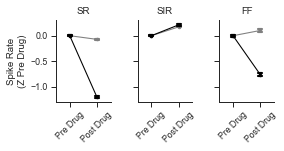

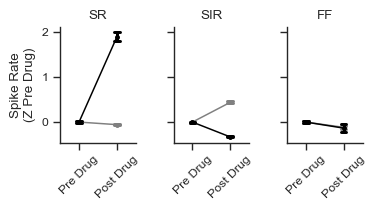

In [5]:


def prepost_catplot(df):
    g = sns.catplot(
        x="block", 
        y="zcounts", 
        col="neuron_type", 
        hue="drug",
        sharey=True,
        sharex=False,
        capsize=0.15, 
        height=1.5, 
        aspect=0.8, 
        color="black",
        kind="point", 
        data=df,
        scale=0.5,
        facet_kws=dict(gridspec_kws=dict(wspace=0.5)),
        palette=sns.color_palette(["grey" ,"black"]), 
    )
    g.set_xlabels("")
    g.set_ylabels("Spike Rate\n(Z Pre Drug)")
    g.set_titles("{col_name}")
    g.set_xticklabels(["Pre Drug", "Post Drug"], rotation=45)
    g.despine()
    g.legend.remove()
    g.figure.align_ylabels()
    return g


g_cit = prepost_catplot(df_cit)
g_cit.savefig(Config.fig_dir / "cit_catplot.png", dpi=300, bbox_inches="tight", transparent=True)

g_way = prepost_catplot(df_way)
g_way.savefig(Config.fig_dir / "way_catplot.png", dpi=300, bbox_inches="tight", transparent=True)


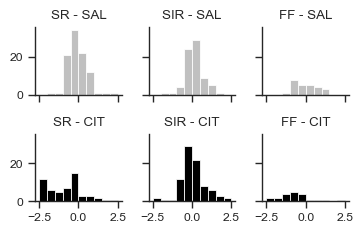

In [6]:
g = sns.FacetGrid(
    data=df_res.query("challenge == 'One'"),
    col="neuron_type",
    row="drug",
    palette=PAL_GREY_BLACK[::-1],
    sharey=True,
    sharex=True,
    height=1.3,
    aspect=1
)
g.map_dataframe(
    sns.histplot, 
    x="Diff_lim", 
    # stat="probability", 
    bins=np.arange(-2.5, 2.6, 0.5),
    multiple="stack",
    alpha=1,
    hue="drug",
    palette=PAL_GREY_BLACK[::-1],
    )
# g.axes_dict
g.set_titles("{col_name} - {row_name}")
g.set_xlabels("")
g.set_ylabels("")

g.savefig(Config.fig_dir / "cit_histplot.png", dpi=300, bbox_inches="tight", transparent=True)

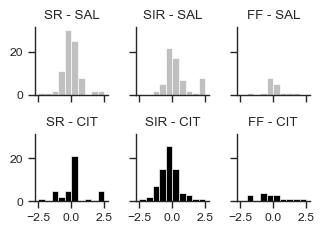

In [7]:
g = sns.FacetGrid(
    data=df_res.query("challenge == 'Two'"),
    col="neuron_type",
    row="drug",
    palette=PAL_GREY_BLACK[::-1],
    sharey=True,
    sharex=True,
    height=1.3,
    aspect=0.9,
    col_order=["SR", "SIR", "FF"]
)
g.map_dataframe(
    sns.histplot, 
    x="Diff_lim", 
    # stat="probability", 
    bins=np.arange(-2.5, 2.6, 0.5),
    multiple="stack",
    alpha=1,
    hue="drug",
    palette=PAL_GREY_BLACK[::-1],
    )
# g.axes_dict
g.set_titles("{col_name} - {row_name}")
g.set_xlabels("")
g.set_ylabels("")

## Heat-maps

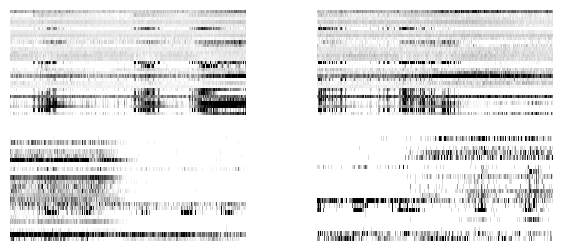

In [8]:
cit_session = cit_sessions[5]
sal_session = sal_sessions[4]
df_cit = load_drug_data(sessions=[cit_session])
df_sal = load_drug_data(sessions=[sal_session])

idx_cit = df_cit.sort_values("neuron_type")[["neuron_id"]].drop_duplicates().neuron_id.values
idx_sal = df_sal.sort_values("neuron_type")[["neuron_id"]].drop_duplicates().neuron_id.values

f = plt.figure(figsize=(7, 3))
axes =f.subplots(2, 2, gridspec_kw=dict(hspace=0.2, wspace=0.3))


population_raster(
    session_name=sal_session, 
    tfidf=False, 
    idx=idx_sal,
    title=False,
    ax=axes[0, 0],
    )

population_raster(
    session_name=cit_session, 
    tfidf=False, 
    idx=idx_cit,
    title=False,
    ax=axes[1, 0],
    )

population_raster(
    session_name=sal_session, 
    block="way",
    tfidf=False, 
    idx=idx_sal,
    title=False,
    ax=axes[0, 1],
    )
population_raster(
    session_name=cit_session, 
    block="way",
    tfidf=False, 
    idx=idx_cit,
    title=False,
    ax=axes[1, 1],
    )


f.savefig(Config.fig_dir / "drug_heats.png", dpi=300, transparent=True, bbox_inches="tight")

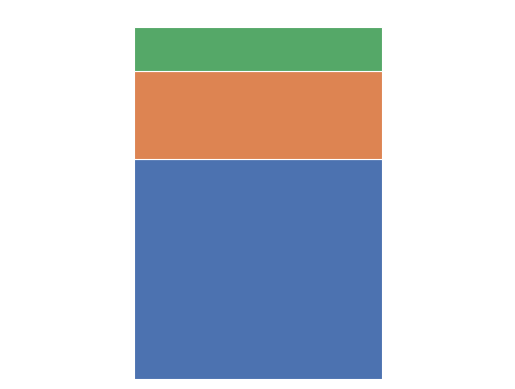

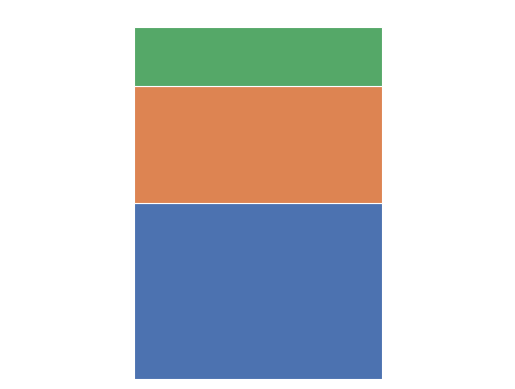

In [9]:
def stacked_bar_single(df, col, ax):
    df[col].value_counts().to_frame().T.plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.axis("off")
    return ax


f = plt.figure()
ax = f.subplots()
ax = stacked_bar_single(df_cit, "neuron_type", ax)
f.savefig(Config.fig_dir / "cit_stacked_bar.png", dpi=300, transparent=True)


f = plt.figure()
ax = f.subplots()
ax = stacked_bar_single(df_sal, "neuron_type", ax)
f.savefig(Config.fig_dir / "sal_stacked_bar.png", dpi=300, transparent=True, bbox_inches="tight")

In [23]:
# proportion of neurons significantly modulated by drug

pd.pivot_table(index=["challenge"], columns=["neuron_type", "drug"], values="sig", aggfunc=np.mean, data=df_res).round(2)

neuron_type    FF         SIR          SR      
drug          SAL   CIT   SAL   CIT   SAL   CIT
challenge                                      
One          0.04  0.38  0.03  0.04  0.02  0.42
Two          0.11  0.16  0.17  0.06  0.05  0.15

In [26]:
# average magnitude of modulation

pd.pivot_table(index=["challenge"], columns=["neuron_type", "drug"], values="Diff", aggfunc=np.mean, data=df_res.query("sig == True")).round(2)

neuron_type    FF         SIR          SR       
drug          SAL   CIT   SAL   CIT   SAL    CIT
challenge                                       
One         -1.35 -1.96 -1.35 -2.28 -1.42  -2.92
Two          1.45  4.25  2.94  1.98  2.19  10.98